In [1]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Read the dataset file for text Summarizer
df=pd.read_csv("text-generator.csv")
# Drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
df.head()
df

,Text,Summary
0,whatsapp must receive or collect some informat...,the purpose of collecting data
1,our services have optional features which if u...,the purpose of collecting additional data
2,your account information you must provide your...,why collecting the account information
3,your messages we do not retain your messages i...,where delivered messages are stored
4,undelivered messages if a message cannot be de...,how to deal with undelivered messages
...,...,...
274,object to or limit or restrict use of data you...,reasons for restricting usage of data
275,access and or take your data you can ask us fo...,requesting personal data
276,account closure you may cancel your account an...,the process of canceling accounts
277,general security in order to protect both the ...,how to protect the security of users


In [3]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
stop_words=set(stopwords.words('english'))

In [4]:
def clean(texts):
    # Tokenize the text into words 
    words=word_tokenize(texts.lower())
    # Contraction file to expand shortened words
    words= [contractions[w] if w in contractions else w for w in words ]
    words= [w for w in words if w not in stop_words]
    return words

In [5]:
# Pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
    in_words= clean(in_txt)
    input_texts+= [' '.join(in_words)]
    input_words+= in_words
    # Add 'start' at start and 'end' at end of text
    tr_words= clean("start "+tr_txt+" end")
    target_texts+= [' '.join(tr_words)]
    target_words+= tr_words

In [6]:
# Store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
# Get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)
# print("maximum target length : ",100)

number of input words :  1676
number of target words :  350
maximum input length :  312
maximum target length :  40


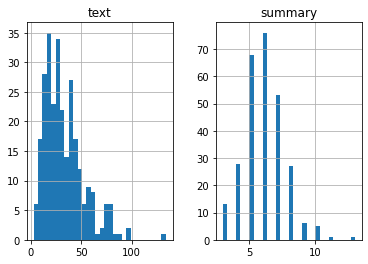

In [7]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in input_texts:
      text_word_count.append(len(i.split()))

for i in target_texts:
      summary_word_count.append(len(i.split()))

# print("text_word_count",text_word_count)
# print("summary_word_count",summary_word_count)
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [8]:
# Split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.1,random_state=40)

# Train the tokenizer with all the words
  # prepare a tokenizer for texts on training data
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
  # preparing a tokenizer for summary on training data 
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
# Convert text into sequence of integers where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

# Pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
# Decoder input data will not include the last word 
# i.e. 'end' in decoder input data
dec_in_data = dec_data[:,:-1]

# Decoder target data will be one time step ahead as it will not include the first word i.e 'start'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [9]:
# Return Sequences = True: When the return sequences 
# parameter is set to True, LSTM produces the hidden 
# state and cell state for every timestep

# Return State = True: When return state = True, 
# LSTM produces the hidden state and cell state of 
# the last timestep only

# Initial State: This is used to initialize the 
# internal states of the LSTM for the first timestep

# Stacked LSTM: Stacked LSTM has multiple layers of 
# LSTM stacked on top of each other. This leads to a
# better representation of the sequence. 

In [10]:
import tensorflow as tf

def add_prefix(model, prefix: str, custom_objects=None):
    '''Adds a prefix to layers and model name while keeping the pre-trained weights
    Arguments:
        model: a tf.keras model
        prefix: a string that would be added to before each layer name
        custom_objects: if your model consists of custom layers you shoud add them pass them as a dictionary. 
            For more information read the following:
            https://keras.io/guides/serialization_and_saving/#custom-objects
    Returns:
        new_model: a tf.keras model having same weights as the input model.
    '''
    
    config = model.get_config()
    old_to_new = {}
    new_to_old = {}
    
    for layer in config['layers']:
        new_name = prefix + layer['name']
        old_to_new[layer['name']], new_to_old[new_name] = new_name, layer['name']
        layer['name'] = new_name
        layer['config']['name'] = new_name

        if len(layer['inbound_nodes']) > 0:
            for in_node in layer['inbound_nodes'][0]:
                in_node[0] = old_to_new[in_node[0]]
    
    for input_layer in config['input_layers']:
        input_layer[0] = old_to_new[input_layer[0]]
    
    for output_layer in config['output_layers']:
        output_layer[0] = old_to_new[output_layer[0]]
    
    config['name'] = prefix + config['name']
    new_model = tf.keras.Model().from_config(config, custom_objects)
    
    for layer in new_model.layers:
        layer.set_weights(model.get_layer(new_to_old[layer.name]).get_weights())
    
    return new_model

In [11]:
K.clear_session() 
latent_dim = 500

# Encoder 
# Create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,),name='input_0')

en_embedding = Embedding(num_in_words+1, latent_dim, name='en_embedding')(en_inputs) 

# Create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
# LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True,name='LSTM1') 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
# LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True,name='LSTM2') 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
# LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True,name='LSTM3')
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
# Encoder states
en_states= [state_h3, state_c3]

# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
# Initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

# Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
# Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

# Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax')
dec_outputs = dec_dense(merge) 

# Model class and model summary for text Summarizer
new_model = Model([en_inputs, dec_inputs], dec_outputs) 
model = add_prefix(new_model, 'v2_')
model.summary()

Model: "v2_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 v2_input_0 (InputLayer)        [(None, 312)]        0           []                               
                                                                                                  
 v2_en_embedding (Embedding)    (None, 312, 500)     838500      ['v2_input_0[0][0]']             
                                                                                                  
 v2_LSTM1 (LSTM)                [(None, 312, 500),   2002000     ['v2_en_embedding[0][0]']        
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                           

In [12]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] 
) 

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [14]:
history=model.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=512, 
    epochs=25, 
    validation_split=0.1,
    )

Epoch 1/25
1/1 [==============================] - 75s 75s/step - loss: 5.8630 - accuracy: 2.2792e-04 - val_loss: 3.8834 - val_accuracy: 0.8677
Epoch 2/25
1/1 [==============================] - 61s 61s/step - loss: 3.8852 - accuracy: 0.8713 - val_loss: 1.2142 - val_accuracy: 0.8677
Epoch 3/25
1/1 [==============================] - 57s 57s/step - loss: 1.1390 - accuracy: 0.8713 - val_loss: 2.3694 - val_accuracy: 0.6667
Epoch 4/25
1/1 [==============================] - 56s 56s/step - loss: 2.3127 - accuracy: 0.6696 - val_loss: 1.0044 - val_accuracy: 0.8677
Epoch 5/25
1/1 [==============================] - 58s 58s/step - loss: 0.8854 - accuracy: 0.8713 - val_loss: 0.7472 - val_accuracy: 0.8677
Epoch 6/25
1/1 [==============================] - 55s 55s/step - loss: 0.6320 - accuracy: 0.8713 - val_loss: 0.7259 - val_accuracy: 0.8708
Epoch 7/25
1/1 [==============================] - 56s 56s/step - loss: 0.6050 - accuracy: 0.8730 - val_loss: 0.7228 - val_accuracy: 0.8718
Epoch 8/25
1/1 [=======

In [18]:
#Save model
model.save("s2s")

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


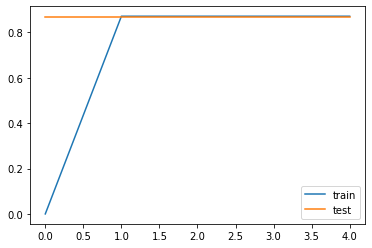

In [19]:
from matplotlib import pyplot 
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.legend() 
pyplot.show()

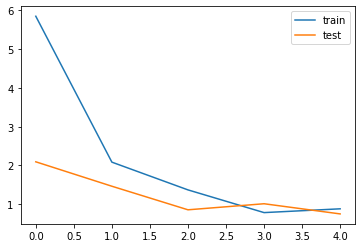

In [20]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [21]:
# Encoder inference
latent_dim=500#load the model
model = models.load_model("s2s")
 
# Construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
# Add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

# Decoder inference
# Create Input object for hidden and cell state for decoder
# Shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
# Add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

# Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

# Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [40]:
# import pickle
# pickle.dump(en_model, open('./en_model.pkl', 'wb'))

In [22]:
# Create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '

In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    # Get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    
    # Target sequence with initial word as 'start'
    target_seq[0, 0] = target_word_index['start']
 
    # If the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    
    # Append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        # Get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        # Get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        
        # Exit condition: either hit max length or find a stop word or last word.
        if text_word == "end" or len(decoded_sentence) > max_tr_len:
            stop_condition = True
            
        # Update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    # Return the decoded sentence
    return decoded_sentence

In [24]:
# inpt_txt = "whatsapp must receive or collect some information to operate provide improve understand customize support and market our services including when you install access or use our services the types of information we receive and collect depend on how you use our services we require certain information to deliver our services and without this we will not be able to provide our services to you for example you must provide your mobile phone number to create an account to use our service"
inpt_txt = "we may collect your personal data when you register for or use our services such as when you create an account make a payment or make a purchase on a merchants website"
# inpt_txt = "4 commercial information for example online shopping cart information purchase history"
print("text :",inpt_txt)
inpt_txt = clean(inpt_txt)
# inpt_txt = ' '.join(inpt_txt)
inp_x= in_tokenizer.texts_to_sequences([inpt_txt]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'end' in summary :
    summary=summary.replace('end','')
print("\nPredicted summary:",summary);print("\n")

text : we may collect your personal data when you register for or use our services such as when you create an account make a payment or make a purchase on a merchants website

Predicted summary:                                           




In [25]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
#After executing this we will be having two file in same directory model.json & model.h5


In [26]:
import pickle
# pickle.dump(model, open('./txt_generator.pkl', 'wb'))
pickle.dump(in_tokenizer, open('./in_tokenizer.pkl', 'wb'))
pickle.dump(tr_tokenizer, open('./tr_tokenizer.pkl', 'wb'))
# pickle.dump(en_in_data, open('./pad_sequences.pkl', 'wb'))

In [27]:
in_tokenizer = pickle.load(open('in_tokenizer.pkl', 'rb'))
in_tokenizer

In [28]:
tr_tokenizer = pickle.load(open('tr_tokenizer.pkl', 'rb'))
tr_tokenizer